# Clusterizacao

[**Premier League Data**](https://www.kaggle.com/thesiff/premierleague1819)

## Carregando bibliotecas

In [52]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from subprocess import call
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import numpy as np
import sklearn as sk 
from numpy import random
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import os
pd.options.display.max_rows = 2000
%matplotlib inline

In [53]:
df_epl = pd.read_csv(os.path.join(os.path.abspath(''), "data/epl_1819.csv"))
df_transfer = pd.read_csv(os.path.join(os.path.abspath(''), "data/transfer.csv"))

df = df_epl.join(df_transfer)

# Drop de team por ficar duplicado apos o join
df.drop(columns="team", inplace=True)

df.head(1)

,Team,category,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,...,end_2018,end_2017,end_2016,end_2015,end_2014,end_2013,end_2012,end_2011,end_2010,Total
0,Manchester City,Champions League,1,26,150986355,38,32,2,4,95,...,-226.15,-178.15,-140.86,-57.68,-104.7,-17.65,-59.85,-146.46,-116.35,-1070.83


# Identificando dados faltando

In [54]:
missing = df.isna().mean().gt(0)
missing[missing == True]

Series([], dtype: bool)

Nenhuma coluna possui dados faltando

# Identificando atributos categoricos

In [55]:
obj_attrs = df.select_dtypes("object").columns.values
df[obj_attrs].head(3)

,Team,category,attack_passes,attack_passes_long,attack_passes_back,defence_clearances
0,Manchester City,Champions League,"26,581","1,814","4,240",543
1,Liverpool,Champions League,"23,638","2,250","3,416",639
2,Chelsea,Champions League Qualification,"25,070","1,774","3,874",593


Os atributos `attack_passes`, `attack_passes_long`, `attack_passes_back` e `defence_clearances` são numericos mas foram entendidos como object porque utilizam de virgula para separador de milhar. 

Podemos entao converter esses atributos para formato numerico

In [56]:
transform_attrs = [attr for attr in obj_attrs if attr != "category" and attr != "Team"]
df[transform_attrs] = df[transform_attrs].apply(lambda x: x.str.replace(",", "").astype(int), axis=0)

In [57]:
df[transform_attrs].head(2)

,attack_passes,attack_passes_long,attack_passes_back,defence_clearances
0,26581,1814,4240,543
1,23638,2250,3416,639


O atributos `category` é categorico cardinal e deve ser transformado atravez de algo como one-hot-encoding.

O atributo `Team` pode ser usado como indice.

In [58]:
df = pd.get_dummies(df, columns=["category"]).set_index("Team")
df.head(5)

,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,defence_goals_conceeded,general_goal_difference,...,end_2012,end_2011,end_2010,Total,category_Champions League,category_Champions League Qualification,category_Europa League,category_Europa League Qualification,category_No UEFA Competitions,category_Relegated
Team,,,,,,,,,,,,,,,,,,,,,
Manchester City,1,26,150986355,38,32,2,4,95,23,72,...,-59.85,-146.46,-116.35,-1070.83,1,0,0,0,0,0
Liverpool,2,29,152425146,38,30,7,1,89,22,67,...,-47.84,-11.99,77.07,-666.55,1,0,0,0,0,0
Chelsea,3,25,146030216,38,21,9,8,63,39,24,...,33.80,-23.67,-8.60,-16.78,0,1,0,0,0,0
Tottenham,4,26,145230801,38,23,2,13,67,39,28,...,-43.63,3.98,5.05,-324.86,0,1,0,0,0,0
Arsenal,5,25,142193180,38,21,7,10,73,51,22,...,-64.05,-105.00,-26.20,-560.93,0,0,1,0,0,0


# Clusterizacao
Será utilizada a metrica silhouette como indicador da qualidade dos agrupamentos

## Sem normalizacao

In [59]:
silhouette_values = []
for i in range (2, 20):
    kmeans = KMeans(n_clusters=i).fit(df)
    hierarquico = AgglomerativeClustering(n_clusters=i)


    km_clustered = df.assign(cluster_number=kmeans.predict(df))
    h_clustered = df.assign(cluster_number=hierarquico.fit_predict(df))

  
    silhouette_values.append({
        "n_clusters": i,
        "silhouette_km": sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"]),
        "silhouette_h": sk.metrics.silhouette_score(h_clustered, labels=h_clustered["cluster_number"]),
    })


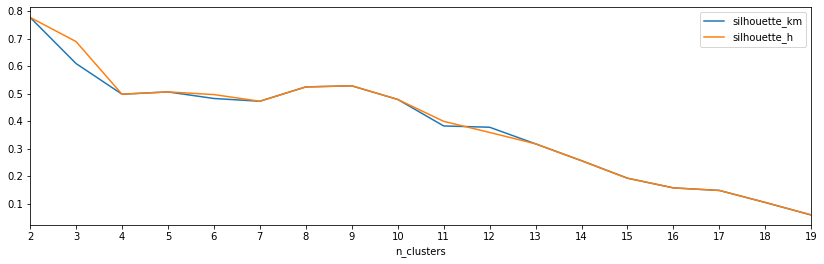

In [60]:
pd.DataFrame(silhouette_values).plot.line(x="n_clusters", 
                                             y=["silhouette_km", "silhouette_h"],
                                             xticks=range(2,20),
                                             figsize=[14,4])

# Normalização dos atributos

In [61]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

df = pd.DataFrame(scaler.fit_transform(df),columns=df.columns.values, index=df.reset_index()["Team"])

In [62]:
df.head(2)

,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,defence_goals_conceeded,general_goal_difference,...,end_2012,end_2011,end_2010,Total,category_Champions League,category_Champions League Qualification,category_Europa League,category_Europa League Qualification,category_No UEFA Competitions,category_Relegated
Team,,,,,,,,,,,,,,,,,,,,,
Manchester City,-1.647509,1.355819,1.587439,0.0,2.341753,-2.138031,-1.733109,2.350452,-1.992988,2.281980,...,-2.016336,-3.390784,-3.403626,-3.345767,3.0,-0.333333,-0.333333,-0.229416,-1.0,-0.420084
Liverpool,-1.474087,1.812837,1.668472,0.0,2.058762,-0.041922,-2.187198,2.009807,-2.058119,2.123509,...,-1.538152,0.065596,2.296763,-1.719834,3.0,-0.333333,-0.333333,-0.229416,-1.0,-0.420084


# Clusterizacao apos normalizacao

In [63]:
silhouette_values = []
for i in range (2, 20):
    kmeans = KMeans(n_clusters=i).fit(df)
    hierarquico = AgglomerativeClustering(n_clusters=i)


    km_clustered = df.assign(cluster_number=kmeans.predict(df))
    h_clustered = df.assign(cluster_number=hierarquico.fit_predict(df))

  
    silhouette_values.append({
        "n_clusters": i,
        "silhouette_km": sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"]),
        "silhouette_h": sk.metrics.silhouette_score(h_clustered, labels=h_clustered["cluster_number"]),
    })


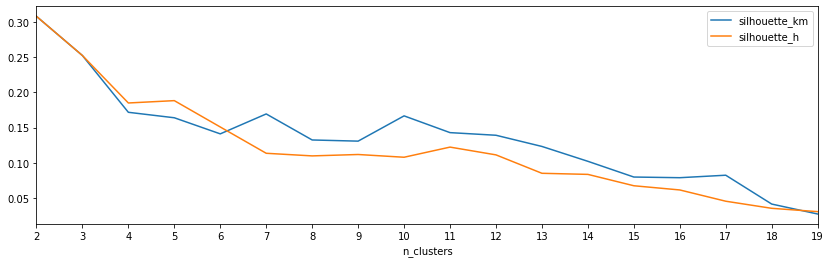

In [64]:
pd.DataFrame(silhouette_values).plot.line(x="n_clusters", 
                                             y=["silhouette_km", "silhouette_h"],
                                             xticks=range(2,20),
                                             figsize=[14,4])

Apos normalizacao aparentemente a performance de ambos algoritmos caiu dastricamente, principalmente para numero de agrupamentos igual a 2.

# Redução de dimensionalidade 

Os resultados atingidos foram muito ruins, numa tentativa de melhora-los sera utilizado **PCA ( Principal Component Analysis )** para redução de dimensionalidade 

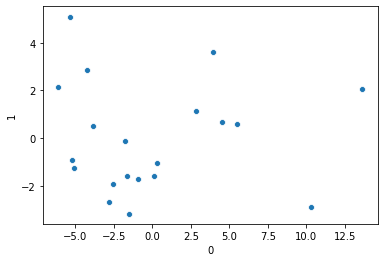

In [65]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

pca = PCA(n_components=2)

df_proj = pd.DataFrame(pca.fit_transform(df), index=df.reset_index()["Team"])

sns.scatterplot(x=df_proj[0], y=df_proj[1])

Apesar do baixo numero de instancias ja e possivel observar alguns agrupamentos apos a reducao de dimensionalidade.

In [70]:
silhouette_values = []
for i in range (2, 20):
    kmeans = KMeans(n_clusters=i).fit(df_proj)
    hierarquico = AgglomerativeClustering(n_clusters=i)


    km_clustered = df_proj.assign(cluster_number=kmeans.predict(df_proj))
    h_clustered = df_proj.assign(cluster_number=hierarquico.fit_predict(df_proj))

  
    silhouette_values.append({
        "n_clusters": i,
        "silhouette_km": sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"]),
        "silhouette_h": sk.metrics.silhouette_score(h_clustered, labels=h_clustered["cluster_number"]),
    })


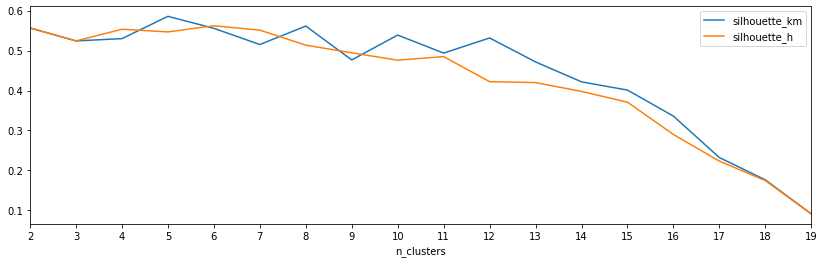

In [71]:
pd.DataFrame(silhouette_values).plot.line(x="n_clusters", 
                                             y=["silhouette_km", "silhouette_h"],
                                             xticks=range(2,20),
                                             figsize=[14,4])

Kmeans atingiu melhor resultado com K=5 e hierarquico com K=6

## Metricas para diferentes valores de max_iterations em K-Means

In [84]:
silhouette_values = []
for i in range (0, 101, 10):
    kmeans = KMeans(n_clusters=5, max_iter=i if i > 0 else 1).fit(df_proj)

    km_clustered = df_proj.assign(cluster_number=kmeans.predict(df_proj))

    silhouette_values.append({
        "max_iter": i,
        "silhouette_km": sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"]),
    })

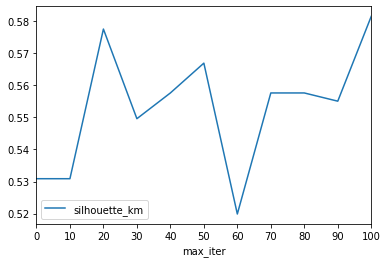

In [85]:
pd.DataFrame(silhouette_values).plot.line(x="max_iter",
                                          y="silhouette_km",
                                          xticks=range(0,101,10))

A melhor metrica foi a associada a max_iter de 100, mas foi percebido que a cada nova amostragem o grafico parecia muito diferente

## KMeans com n_clusters=5 e max_iter=100


In [371]:
kmeans = KMeans(n_clusters=5, max_iter=100).fit(df_proj)

km_clustered = df_proj.assign(cluster_number=kmeans.predict(df_proj))

sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"])

0.6017331856222414

# Metricas para diferentes linkages

In [373]:
silhouette_values = []
for i in ["ward", "complete", "average", "single"]:
    hierarquico = AgglomerativeClustering(n_clusters=5, linkage=i)

    km_clustered = df_proj.assign(cluster_number=hierarquico.fit_predict(df_proj))

    silhouette_values.append({
        "linkage": i,
        "silhouette_km": sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"]),
    })

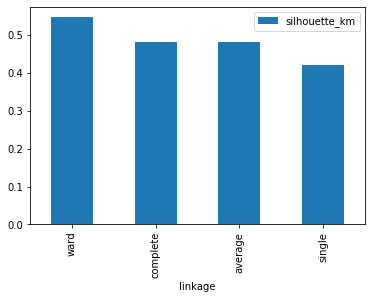

In [374]:
pd.DataFrame(silhouette_values).plot.bar(x="linkage", y="silhouette_km")

A melhor linkage foi `ward`

# Comparando os melhores resultados para os dois algoritmos

Silhouette:  0.5859423979840417


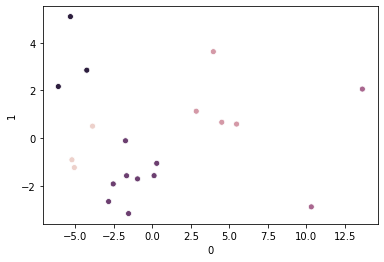

In [407]:
kmeans = KMeans(n_clusters=5, max_iter=100).fit(df_proj)

km_clustered = df_proj.assign(cluster_number=kmeans.predict(df_proj))

sns.scatterplot(x=km_clustered[0],
                y=km_clustered[1],
                hue=km_clustered["cluster_number"],
                legend=False)
print("Silhouette: ", sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"]))

Silhouette:  0.5623364818261255


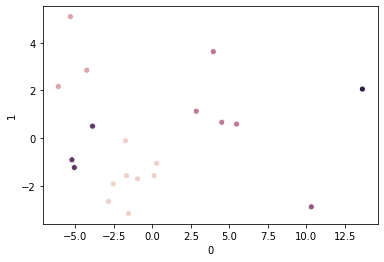

In [408]:
hierarquico = AgglomerativeClustering(n_clusters=6, linkage="ward")
h_clustered =  df_proj.assign(cluster_number=hierarquico.fit_predict(df_proj))
sns.scatterplot(x=h_clustered[0],
                y=h_clustered[1],
                hue=h_clustered["cluster_number"],
                legend=False)
print("Silhouette: ", sk.metrics.silhouette_score(h_clustered, labels=h_clustered["cluster_number"]))

In [409]:
pd.DataFrame([sk.metrics.silhouette_score(km_clustered, labels=km_clustered["cluster_number"]),
sk.metrics.silhouette_score(h_clustered, 
                            labels=h_clustered["cluster_number"])],
                            index=["K-Means", "Hierarquico"],
                            columns=["silhouette"])

,silhouette
K-Means,0.585942
Hierarquico,0.562336


## Consideracoes sobre os resultados

O agrupamento hierarquico classificou as duas instancias mais distantes do resto do dataset - canto superior e inferior direito no grafico acima - como estando em dois grupos diferentes, ja o K-Means consistentemente as agrupou em um unico cluster. Talvez esse seja o motivo da diferenca no silhouette_score.

# Analisando os grupos

## Revertendo scaling

Podemos simplesmente utilizar o df original

In [410]:
df_original = df_epl.join(df_transfer)

# Drop de team por ficar duplicado apos o join
df_original.drop(columns="team", inplace=True)
df_with_clusters = df_original.set_index("Team").assign(cluster_number= km_clustered["cluster_number"])

## Posicao do time de acordo com seu agrupamento

In [411]:
df_with_clusters[["general_league_position", "cluster_number"]].groupby("cluster_number").agg(["mean", "std"])

general_league_position          
                                  mean       std
cluster_number                                  
0                                 16.0  1.000000
1                                  4.5  1.290994
2                                  1.5  0.707107
3                                 10.5  2.449490
4                                 19.0  1.000000

Os agrupamentos de fato refletem a posicao dos times na liga

## Agrupamentos e porcentagem de vitoria

In [412]:
percentWon = df_with_clusters["general_won"] / df_with_clusters["general_matches_played"] * 100
df_with_clusters.assign(percentWon=percentWon)[["percentWon", "cluster_number"]].sort_values(by="cluster_number").groupby("cluster_number").agg(["mean", "std"])



percentWon          
                     mean       std
cluster_number                     
0               25.438596  3.038686
1               55.263158  4.297350
2               81.578947  3.721615
3               37.500000  3.373000
4               17.543860  9.241802

Os agrupamentos de fato refletem a porcentagem de vitoria dos times

## Visualizando todos os atributos em cada agrupamento

In [413]:
df_with_clusters[df_with_clusters["cluster_number"] == 0]

,category,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,defence_goals_conceeded,...,end_2017,end_2016,end_2015,end_2014,end_2013,end_2012,end_2011,end_2010,Total,cluster_number
Team,,,,,,,,,,,,,,,,,,,,,
Burnley,No UEFA Competitions,15,11,107340558,38,11,7,20,45,68,...,-8.75,-13.45,9.42,4.65,-0.67,-4.15,-0.65,-0.43,-151.29,0
Southampton,No UEFA Competitions,16,10,104302937,38,9,12,17,45,65,...,-3.00,9.77,3.38,-0.83,6.65,1.01,0.32,-1.73,-73.71,0
Brighton,No UEFA Competitions,17,13,105741728,38,9,9,20,35,60,...,16.15,-7.40,27.79,-35.40,-41.50,8.73,-2.82,2.25,-33.44,0


In [414]:
df_with_clusters[df_with_clusters["cluster_number"] == 1]

,category,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,defence_goals_conceeded,...,end_2017,end_2016,end_2015,end_2014,end_2013,end_2012,end_2011,end_2010,Total,cluster_number
Team,,,,,,,,,,,,,,,,,,,,,
Chelsea,Champions League Qualification,3,25,146030216,38,21,9,8,63,39,...,-31.30,16.58,-4.32,13.55,-0.47,33.80,-23.67,-8.60,-16.78,1
Tottenham,Champions League Qualification,4,26,145230801,38,23,2,13,67,39,...,5.48,-34.85,-52.16,-25.50,-60.15,-43.63,3.98,5.05,-324.86,1
Arsenal,Europa League,5,25,142193180,38,21,7,10,73,51,...,-24.40,-3.01,7.15,-52.92,-84.25,-64.05,-105.00,-26.20,-560.93,1
Manchester United,Europa League,6,27,142512868,38,19,9,10,65,54,...,-102.65,-24.00,-91.18,-37.10,9.85,12.82,-13.40,35.70,-281.72,1


In [415]:
df_with_clusters[df_with_clusters["cluster_number"] == 2]

,category,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,defence_goals_conceeded,...,end_2017,end_2016,end_2015,end_2014,end_2013,end_2012,end_2011,end_2010,Total,cluster_number
Team,,,,,,,,,,,,,,,,,,,,,
Manchester City,Champions League,1,26,150986355,38,32,2,4,95,23,...,-178.15,-140.86,-57.68,-104.70,-17.65,-59.85,-146.46,-116.35,-1070.83,2
Liverpool,Champions League,2,29,152425146,38,30,7,1,89,22,...,-137.85,-53.93,-146.06,-75.33,-65.57,-47.84,-11.99,77.07,-666.55,2


In [416]:
df_with_clusters[df_with_clusters["cluster_number"] == 3]

,category,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,defence_goals_conceeded,...,end_2017,end_2016,end_2015,end_2014,end_2013,end_2012,end_2011,end_2010,Total,cluster_number
Team,,,,,,,,,,,,,,,,,,,,,
Wolverhampton,Europa League Qualification,7,15,127165114,38,16,9,13,47,46,...,-44.40,-5.01,-12.62,4.65,6.35,2.72,0.88,-13.45,-71.63,3
Everton,No UEFA Competitions,8,18,128603905,38,15,9,14,54,46,...,-25.10,-37.90,-38.26,14.30,-2.90,19.60,4.90,5.04,-208.19,3
Leicester,No UEFA Competitions,9,15,123328078,38,15,7,16,51,48,...,-25.55,-40.45,-22.86,0.65,-1.72,-16.71,-2.50,-0.81,-168.69,3
West Ham,No UEFA Competitions,10,16,122528663,38,15,7,16,52,55,...,37.13,-103.28,-21.41,22.07,-17.17,-10.01,27.77,20.79,-85.16,3
Watford,No UEFA Competitions,11,10,113895527,38,14,8,16,52,59,...,-51.10,-23.40,-28.41,-33.00,14.67,-0.77,-0.65,4.40,-175.72,3
Crystal Palace,No UEFA Competitions,12,12,114215215,38,14,7,17,51,53,...,-15.20,-54.46,-1.12,-4.06,-0.63,0.52,1.94,0.00,-176.20,3
Newcastle,No UEFA Competitions,13,19,120130418,38,12,9,17,42,48,...,-42.50,-34.19,-30.75,-23.47,-18.85,-2.49,-10.88,19.65,-221.72,3
Bournemouth,No UEFA Competitions,14,10,108139973,38,13,6,19,56,70,...,-11.85,-73.78,-8.45,2.08,3.99,7.19,-0.73,7.31,-107.16,3


In [417]:
df_with_clusters[df_with_clusters["cluster_number"] == 4]

,category,general_league_position,finance _live_games_televised,finance _tv_revenue,general_matches_played,general_won,general_draw,general_lost,attack_scored,defence_goals_conceeded,...,end_2017,end_2016,end_2015,end_2014,end_2013,end_2012,end_2011,end_2010,Total,cluster_number
Team,,,,,,,,,,,,,,,,,,,,,
Cardiff,Relegated,18,12,102704107,38,10,4,24,34,69,...,-33.11,5.73,-2.02,4.26,15.15,-9.45,-13.78,-18.58,-159.30,4
Fulham,Relegated,19,13,101904692,38,7,5,26,34,81,...,2.68,5.90,12.98,-42.08,-11.55,-0.92,0.34,-1.23,-95.09,4
Huddersfield,Relegated,20,10,96628865,38,3,7,28,22,76,...,-1.77,0.86,0.47,-25.35,21.42,-10.68,1.56,-7.11,-129.47,4
